In [1]:
import pandas as pd
import numpy as np
import biom

from gemelli.rpca import feature_correlation_table
from gemelli.rpca import joint_rpca
from skbio.stats.distance import permanova

#plotting
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
def ordination_scatterplots(rpca_results, metadata, x="PC1", y="PC2",
                            hue=None, hue_order=None, palette="tab10", 
                            markers=None, style=None, style_order=None, 
                            point_size=100, subplots=(2,3), figsize=(25, 10)):

    if subplots is not None:
        fig, axn = plt.subplots(subplots[0], subplots[1], figsize=figsize)
        axn = axn.flatten()
    else:
        fig = plt.figure(figsize=figsize)
        axn = [plt.gca()]

    for ax, (tblid, (ord_, _, _)) in zip(axn, rpca_results.items()):
        #prepare dataframe
        ord_samples = ord_.samples.rename(columns={0:'PC1', 1:'PC2', 
                                                   2:'PC3', 3:'PC4'})
        ord_plt = pd.concat([ord_samples, metadata], axis=1, sort=True)
        
        #plotting
        sns.scatterplot(x=x, y=y, hue=hue, hue_order=hue_order, 
                        palette=palette, style=style, 
                        style_order=style_order, markers=markers, 
                        data=ord_plt, s=point_size, ax=ax)
        ax.set_xlabel(x, color='black', weight='bold', fontsize=22)
        ax.set_ylabel(y, color='black', weight='bold', fontsize=22)
        ax.set_title(tblid, color='black', weight='bold', fontsize=22)
        # fix backround
        ax.set_facecolor('white')
        ax.set_axisbelow(True)
        ax.spines['right'].set_visible(False)
        ax.spines['left'].set_visible(True)
        ax.spines['bottom'].set_visible(True)
        ax.spines['top'].set_visible(False)
        for child in ax.get_children():
            if isinstance(child, matplotlib.spines.Spine):
                child.set_color('grey')

        for tick in ax.get_yticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight('bold')
            tick.set_color("black")
            tick.set_fontsize(14)
        for tick in ax.get_xticklabels():
            tick.set_fontproperties('arial')
            tick.set_weight('bold')
            tick.set_color("black")
            tick.set_fontsize(14)
        ax.legend_.remove()
        
    plt.tight_layout()

    if subplots is not None:
        legend = ax.legend(loc=2, bbox_to_anchor=(-1.1, 2.6),
                           prop={'size':22}, title="",
                           fancybox=True, framealpha=.0,
                           ncol=len(hue_order), markerscale=3.5)
        legend.get_title().set_fontsize('16')
        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
    else:
        legend = ax.legend(loc=2, bbox_to_anchor=(1, 1),
                           prop={'size':18}, title="",
                           fancybox=True, framealpha=.0,
                           ncol=1, markerscale=3.5)
        legend.get_title().set_fontsize('16')
        # increase the line width in the legend 
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        for line in legend.get_lines()[:]:
            line.set_linewidth(2.0)
        
    plt.show()

## Load data

In [4]:
#read-in HNRC-HIV data
hiv_feature = pd.read_csv('../data/HNRC_HIV_feature_table_formatted.tsv', sep='\t', index_col=0)
hiv_metabolomics = pd.read_csv('../data/HNRC_HIV_metabolomics_ft_formatted.csv', index_col=0)
hiv_metadata = pd.read_csv('../data/HNRC_HIV_metadata.tsv', sep='\t', index_col=0)
#read-in U19-Wisconsin data
u19_feature = pd.read_csv('../data/U19_Wisconsin_feature_table_formatted.tsv', sep='\t', index_col=0)
u19_metabolomics = pd.read_csv('../data/U19_Wisconsin_metabolomics_ft_formatted.csv', index_col=0)
u19_metadata = pd.read_csv('../data/U19_Wisconsin_matched_metadata.tsv', sep='\t', index_col=0)

In [5]:
#transform tables in biom format
hiv_feature_table = biom.Table(hiv_feature.values.T, 
                               sample_ids=hiv_feature.index, 
                               observation_ids=hiv_feature.columns)
hiv_metab_table = biom.Table(hiv_metabolomics.values.T, 
                             sample_ids=hiv_metabolomics.index, 
                             observation_ids=hiv_metabolomics.columns)

u19_feature_table = biom.Table(u19_feature.values.T, 
                               sample_ids=u19_feature.index, 
                               observation_ids=u19_feature.columns)
u19_metab_table = biom.Table(u19_metabolomics.values.T, 
                             sample_ids=u19_metabolomics.index, 
                             observation_ids=u19_metabolomics.columns)

## HIV Joint-RPCA

In [51]:
# ONLY RUN ON FIRST ITERATION
ord_jnt, dist_jnt, cv_jnt = joint_rpca([hiv_feature_table, hiv_metab_table],
                                       n_components=3, 
                                       max_iterations=10,
                                       min_feature_count=10,
                                       sample_metadata=hiv_metadata)
hiv_joint_rpca = {'joint': (ord_jnt, dist_jnt, cv_jnt)}

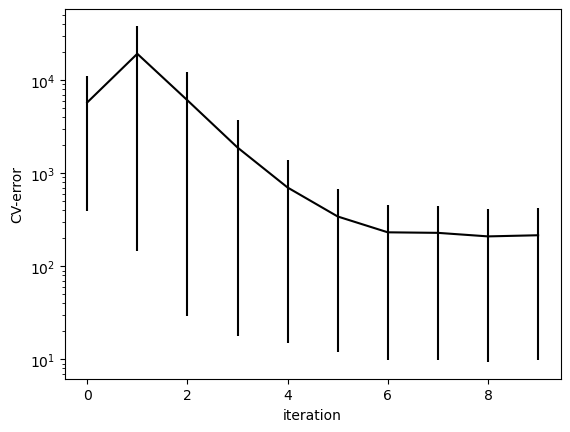

In [52]:
#plot CV error
plt.errorbar(x=hiv_joint_rpca['joint'][2]['iteration'], 
             y=hiv_joint_rpca['joint'][2]['mean_CV'], 
             yerr=hiv_joint_rpca['joint'][2]['std_CV'],
             c='black')
plt.ylabel('CV-error', color='black')
plt.xlabel('iteration', color='black')
plt.yscale('log')
plt.show()

In [53]:
#check eigenvalues and proportion of variance explained
print('Eigenvalues:\n', hiv_joint_rpca['joint'][0].eigvals)
print('Proportion of variance explained:\n', hiv_joint_rpca['joint'][0].proportion_explained)

Eigenvalues:
 PC1    548.354893
PC2      2.573854
PC3      2.293991
dtype: float64
Proportion of variance explained:
 PC1    0.999960
PC2    0.000022
PC3    0.000018
dtype: float64


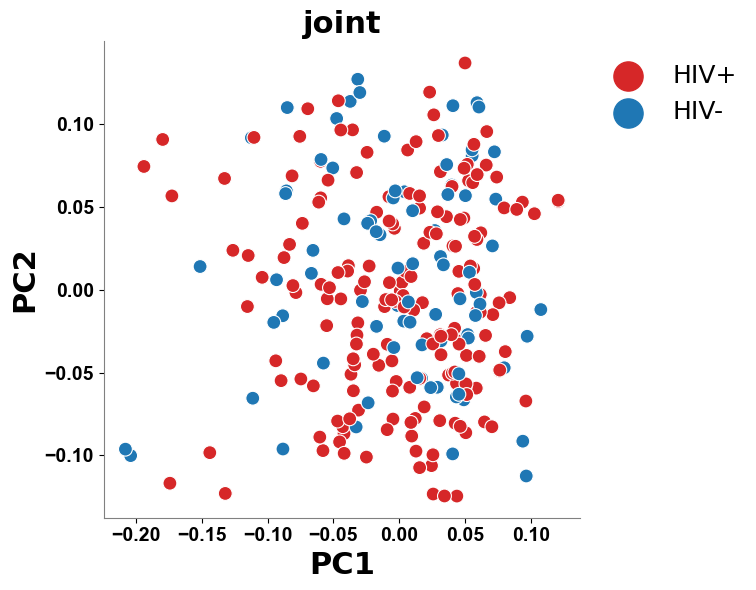

In [9]:
ordination_scatterplots(hiv_joint_rpca, hiv_metadata, 
                        hue="hiv_status", hue_order=['HIV+', 'HIV-'], 
                        x="PC1", y="PC2", palette=["tab:red","tab:blue"], 
                        subplots=None, figsize=(6, 6))

In [47]:
#permanova
hiv_distances = hiv_joint_rpca['joint'][1]
hiv_distances.ids = list(map(str, hiv_distances.ids))
hiv_metadata['hiv_status'] = hiv_metadata['hiv_status'].astype(str)

permanova(hiv_distances, hiv_metadata.loc(axis=0)[hiv_distances.ids]['hiv_status'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     265
number of groups                  3
test statistic             3.218658
p-value                       0.005
number of permutations          999
Name: PERMANOVA results, dtype: object

In [20]:
#plot feature correlation as heatmap
hiv_feature_correlation = feature_correlation_table(hiv_joint_rpca['joint'][0])
hiv_feature_correlation.head(5)

featureid,G000006865,G000006925,G000007325,G000007465,G000007525,G000007785,G000008345,G000008865,G000008925,G000009925,...,28180,19389,30333,23657,29658,25063,23675,28301,29764,29765
featureid,,,,,,,,,,,,,,,,,,,,,
G000006865,1.000000,-0.999707,-0.999842,-0.999841,0.999862,-0.999815,-0.999838,-0.999684,-0.999839,0.999824,...,0.999878,0.999882,0.999871,0.999827,-0.999752,-0.999846,0.999827,0.999878,0.999878,-0.999801
G000006925,-0.999707,1.000000,0.999968,0.999967,-0.999910,0.999983,0.999965,0.999999,0.999968,-0.999949,...,-0.999961,-0.999802,-0.999966,-0.999959,0.999536,0.999954,-0.999968,-0.999962,-0.999958,0.999832
G000007325,-0.999842,0.999968,1.000000,1.000000,-0.999983,0.999997,1.000000,0.999956,1.000000,-0.999995,...,-0.999981,-0.999927,-0.999995,-0.999998,0.999738,0.999998,-0.999999,-0.999985,-0.999976,0.999935
G000007465,-0.999841,0.999967,1.000000,1.000000,-0.999985,0.999997,1.000000,0.999955,1.000000,-0.999996,...,-0.999980,-0.999930,-0.999995,-0.999998,0.999744,0.999999,-1.000000,-0.999984,-0.999974,0.999938
G000007525,0.999862,-0.999910,-0.999983,-0.999985,1.000000,-0.999968,-0.999987,-0.999890,-0.999984,0.999994,...,0.999943,0.999979,0.999970,0.999990,-0.999853,-0.999992,0.999985,0.999950,0.999933,-0.999982


In [21]:
# # plot the correlations (Note: this is taking too long to run)
# plt.figure(figsize=(7, 6))
# sns.clustermap(hiv_feature_correlation,
#                yticklabels=False,
#                xticklabels=False)

# plt.show()

## U19 Joint-RPCA

In [23]:
# ONLY RUN ON FIRST ITERATION
ord_jnt, dist_jnt, cv_jnt = joint_rpca([u19_feature_table, u19_metab_table],
                                        n_components=3, 
                                        max_iterations=15,
                                        min_feature_count=10,
                                        sample_metadata=u19_metadata)
u19_joint_rpca = {'joint': (ord_jnt, dist_jnt, cv_jnt)}

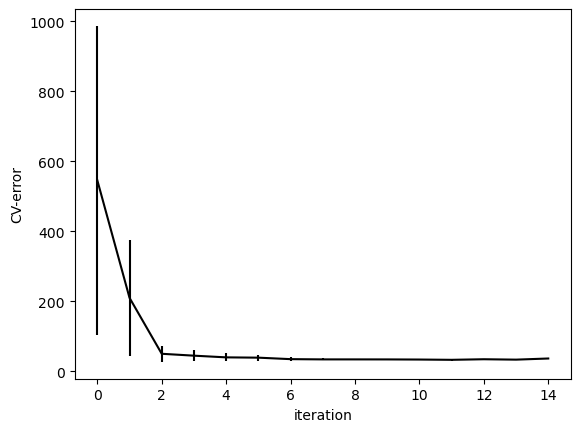

In [24]:
#plot CV error
plt.errorbar(x=u19_joint_rpca['joint'][2]['iteration'], 
             y=u19_joint_rpca['joint'][2]['mean_CV'], 
             yerr=u19_joint_rpca['joint'][2]['std_CV'],
             c='black')
plt.ylabel('CV-error', color='black')
plt.xlabel('iteration', color='black')
#plt.yscale('log')
plt.show()

In [25]:
#check eigenvalues and proportion of variance explained
print('Eigenvalues:\n', u19_joint_rpca['joint'][0].eigvals)
print('Proportion of variance explained:\n', u19_joint_rpca['joint'][0].proportion_explained)

Eigenvalues:
 PC1    368.86071
PC2      2.84228
PC3      2.42415
dtype: float64
Proportion of variance explained:
 PC1    0.999897
PC2    0.000059
PC3    0.000043
dtype: float64


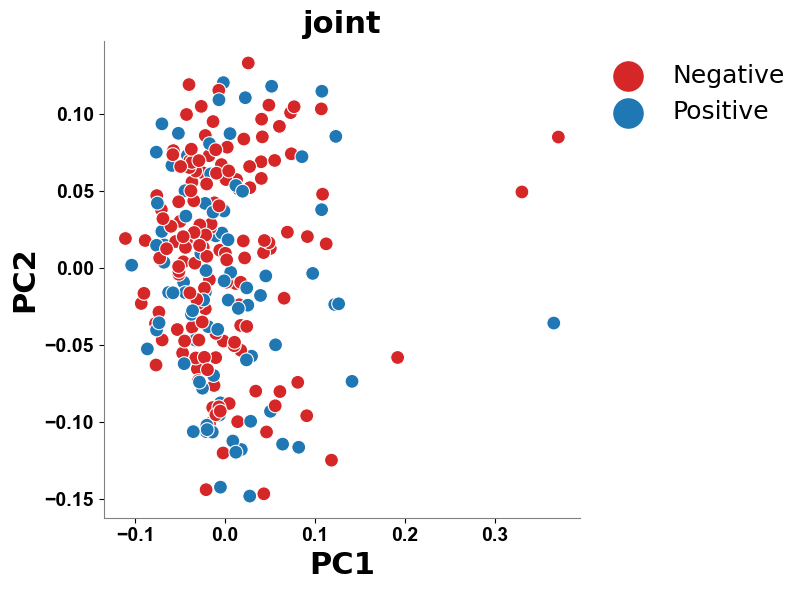

In [26]:
ordination_scatterplots(u19_joint_rpca, u19_metadata, 
                        hue="apoe4", hue_order=['Negative', 'Positive'], 
                        x="PC1", y="PC2", palette=["tab:red","tab:blue"], 
                        subplots=None, figsize=(6, 6))

In [48]:
#permanova
u19_distances = u19_joint_rpca['joint'][1]
u19_distances.ids = list(map(str, u19_distances.ids))
u19_metadata['apoe4'] = u19_metadata['apoe4'].astype(str)

permanova(u19_distances, u19_metadata.loc(axis=0)[u19_distances.ids]['apoe4'])

method name               PERMANOVA
test statistic name        pseudo-F
sample size                     237
number of groups                  3
test statistic              1.23444
p-value                       0.262
number of permutations          999
Name: PERMANOVA results, dtype: object

In [29]:
#plot feature correlation as heatmap
u19_feature_correlation = feature_correlation_table(u19_joint_rpca['joint'][0])
u19_feature_correlation.head(5)

featureid,G000006865,G000006925,G000007325,G000007465,G000007525,G000007785,G000008865,G000009205,G000009925,G000010145,...,quinine,salicylic acid CollisionEnergy:102040,skullcapflavone II,sophocarpine,spiciferinone,suberosin,syringaresinol,triamterene CollisionEnergy:102040,veratramine,verruculotoxin
featureid,,,,,,,,,,,,,,,,,,,,,
G000006865,1.000000,-0.998486,-0.998431,-0.894713,0.999025,0.999570,-0.998485,0.999474,0.998932,-0.999201,...,0.998736,0.998786,0.998338,0.997011,0.998821,-0.998646,-0.998878,0.998980,-0.998284,0.995900
G000006925,-0.998486,1.000000,0.994637,0.874921,-0.999915,-0.999601,1.000000,-0.999686,-0.999794,0.999883,...,-0.999985,-0.999979,-0.999931,-0.998710,-0.999975,0.999990,0.999898,-0.999906,0.999833,-0.999148
G000007325,-0.998431,0.994637,1.000000,0.918318,-0.995404,-0.996520,0.994632,-0.996294,-0.994954,0.995894,...,-0.995184,-0.995079,-0.994870,-0.994933,-0.995150,0.995043,0.994983,-0.995251,0.995097,-0.991751
G000007465,-0.894713,0.874921,0.918318,1.000000,-0.877302,-0.882430,0.874887,-0.881294,-0.874428,0.879963,...,-0.877519,-0.876357,-0.877760,-0.887445,-0.876680,0.877024,0.874995,-0.876408,0.879922,-0.869918
G000007525,0.999025,-0.999915,-0.995404,-0.877302,1.000000,0.999876,-0.999915,0.999922,0.999950,-0.999984,...,0.999938,0.999978,0.999754,0.998260,0.999981,-0.999920,-0.999986,0.999997,-0.999623,0.998534


<Figure size 700x600 with 0 Axes>

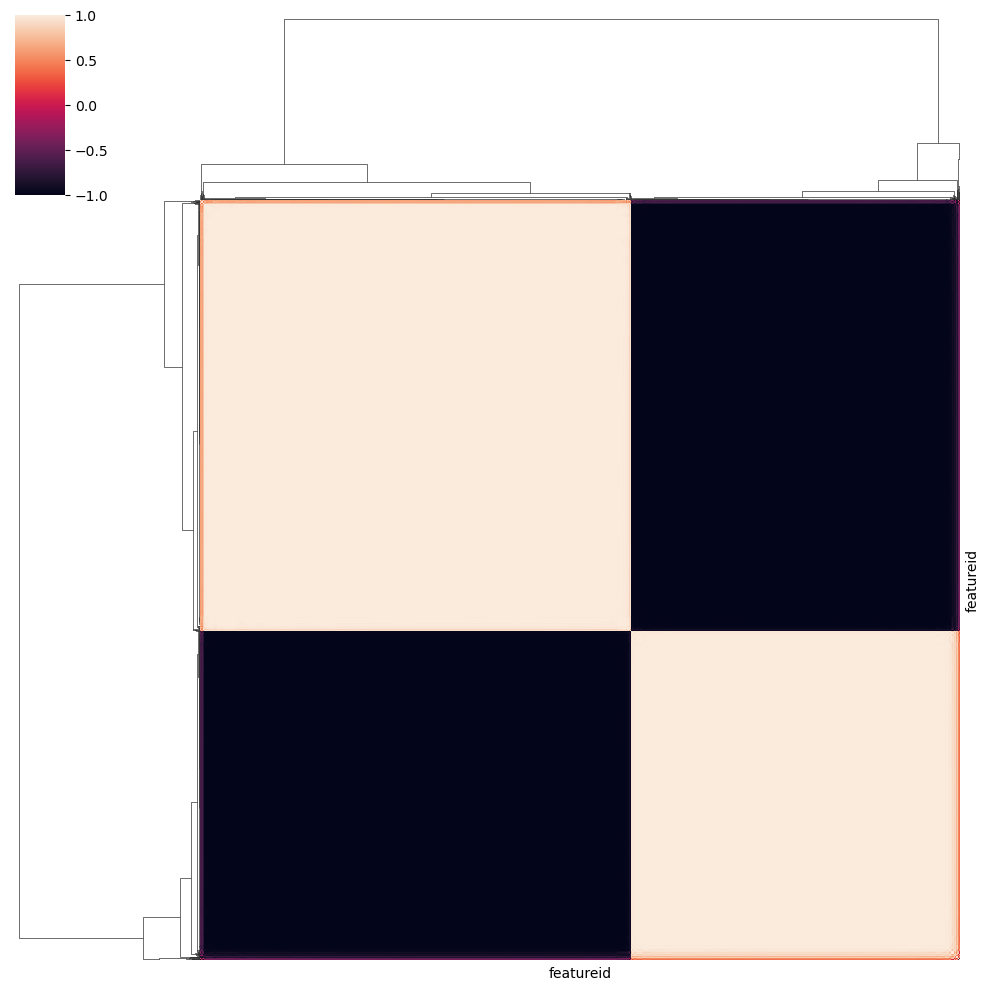

In [30]:
# plot the correlations
plt.figure(figsize=(7, 6))
p = sns.clustermap(u19_feature_correlation,
                   yticklabels=False,
                   xticklabels=False)
plt.show()